In [52]:
from collections import defaultdict
from itertools import product
from tqdm import tqdm
from tqdm.contrib import itertools
from IPython.display import clear_output

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

# Base problem

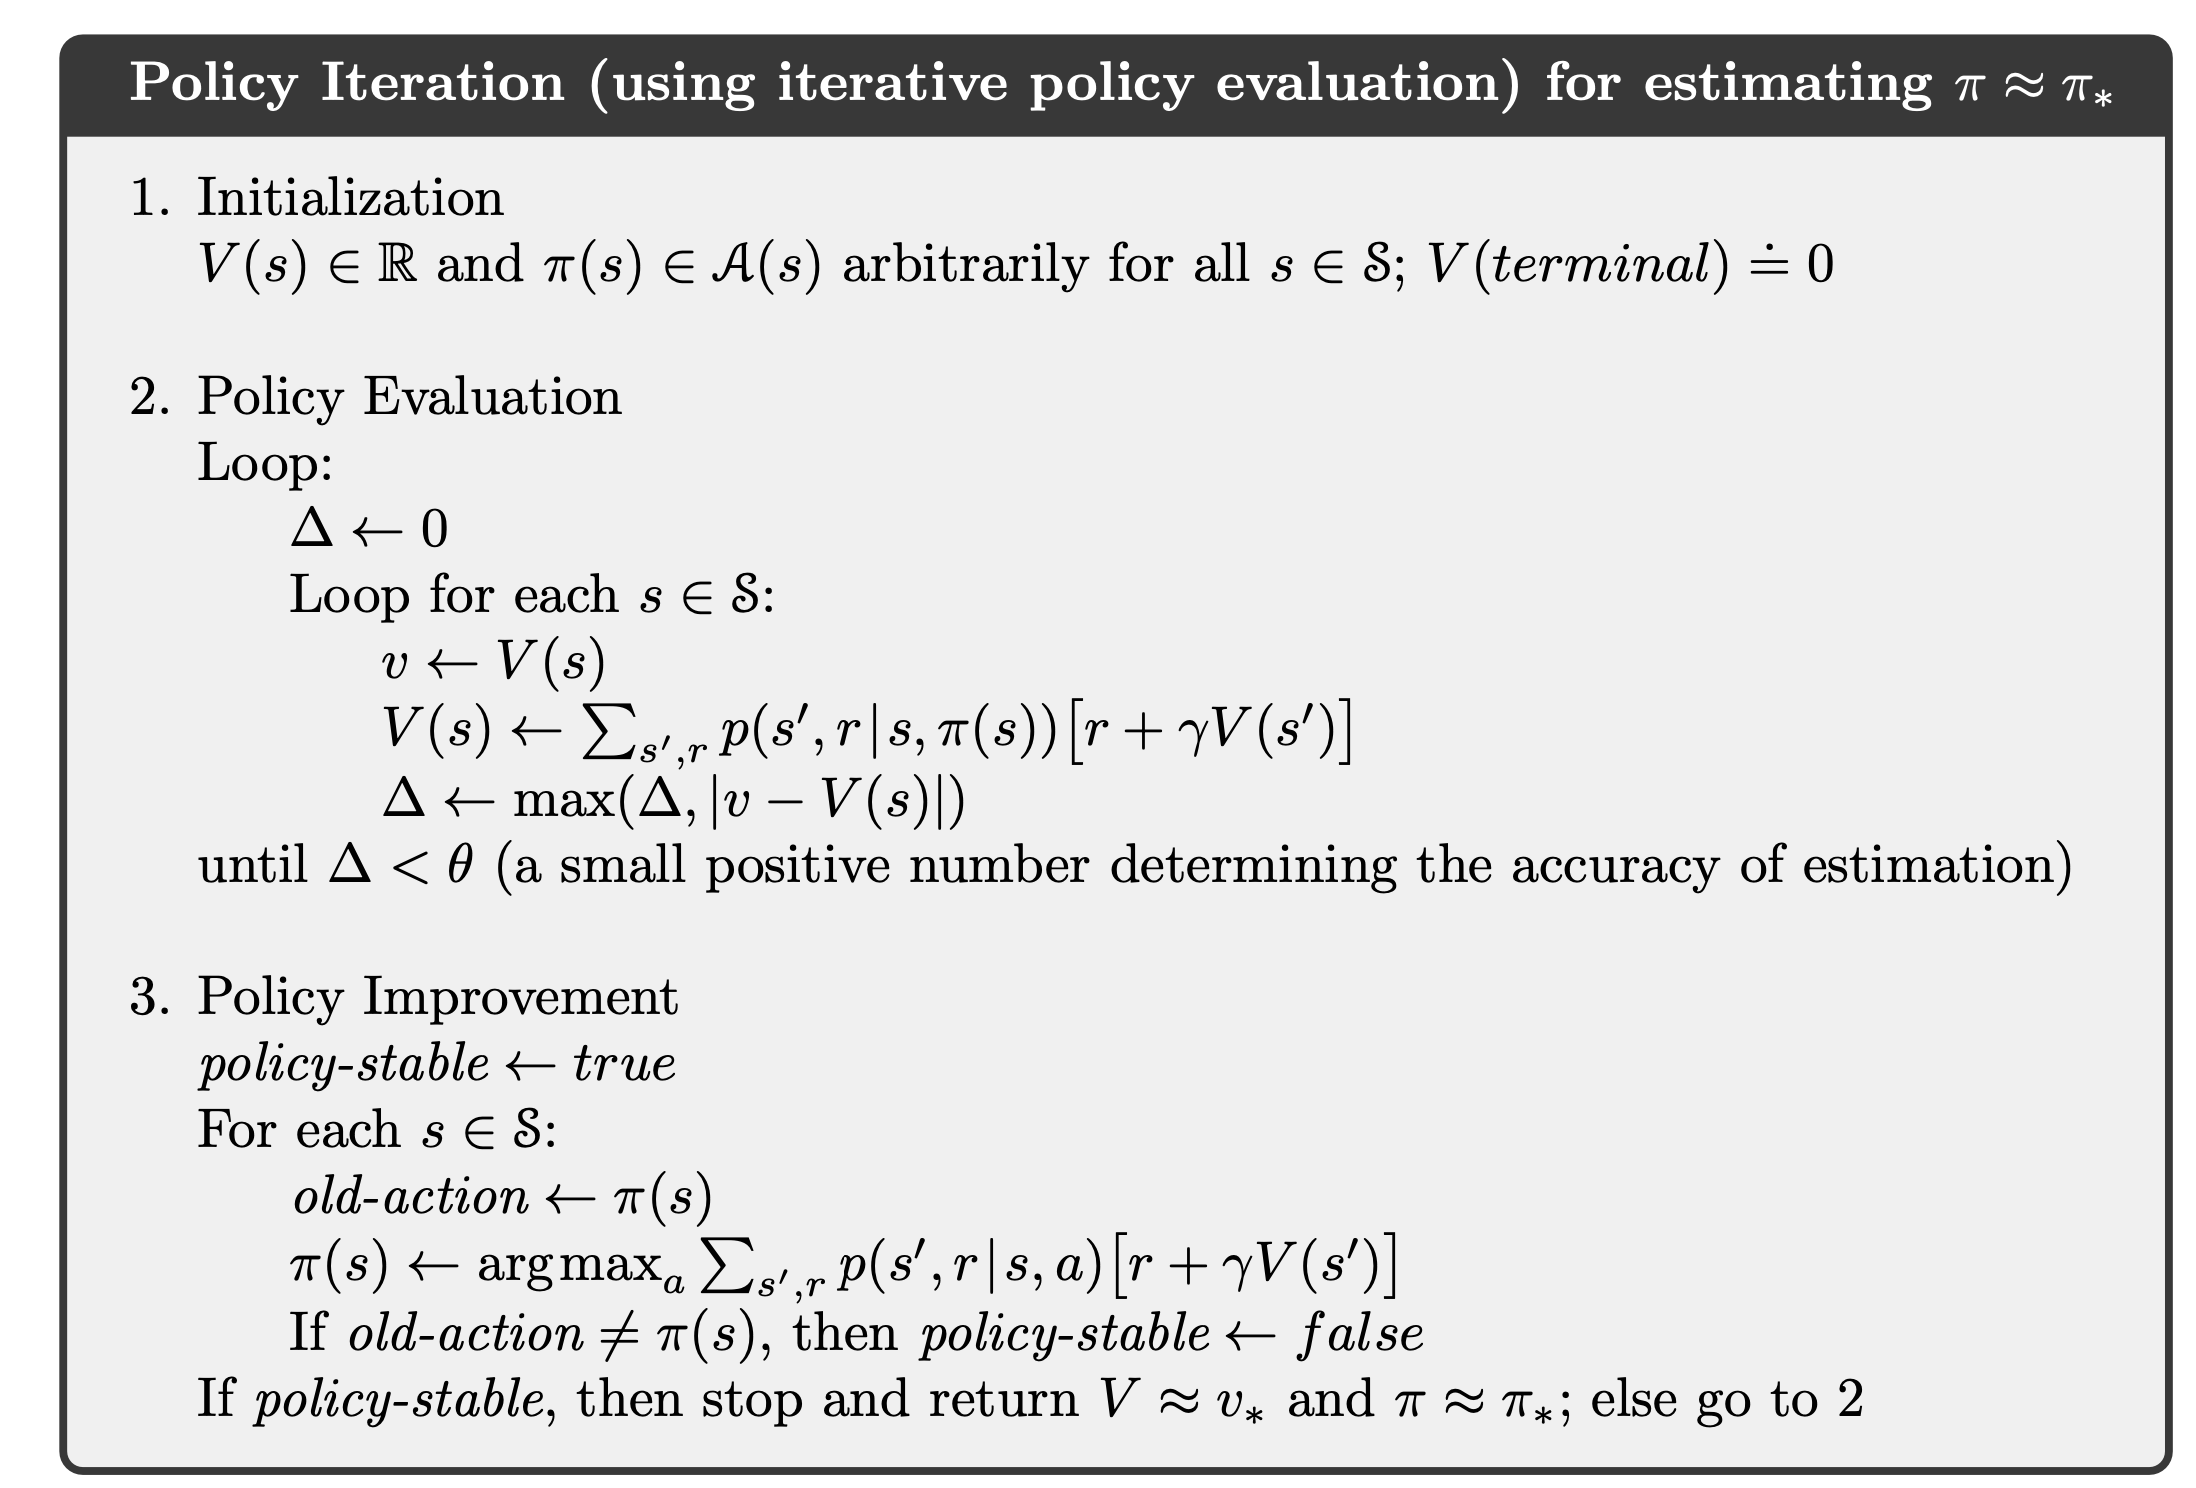
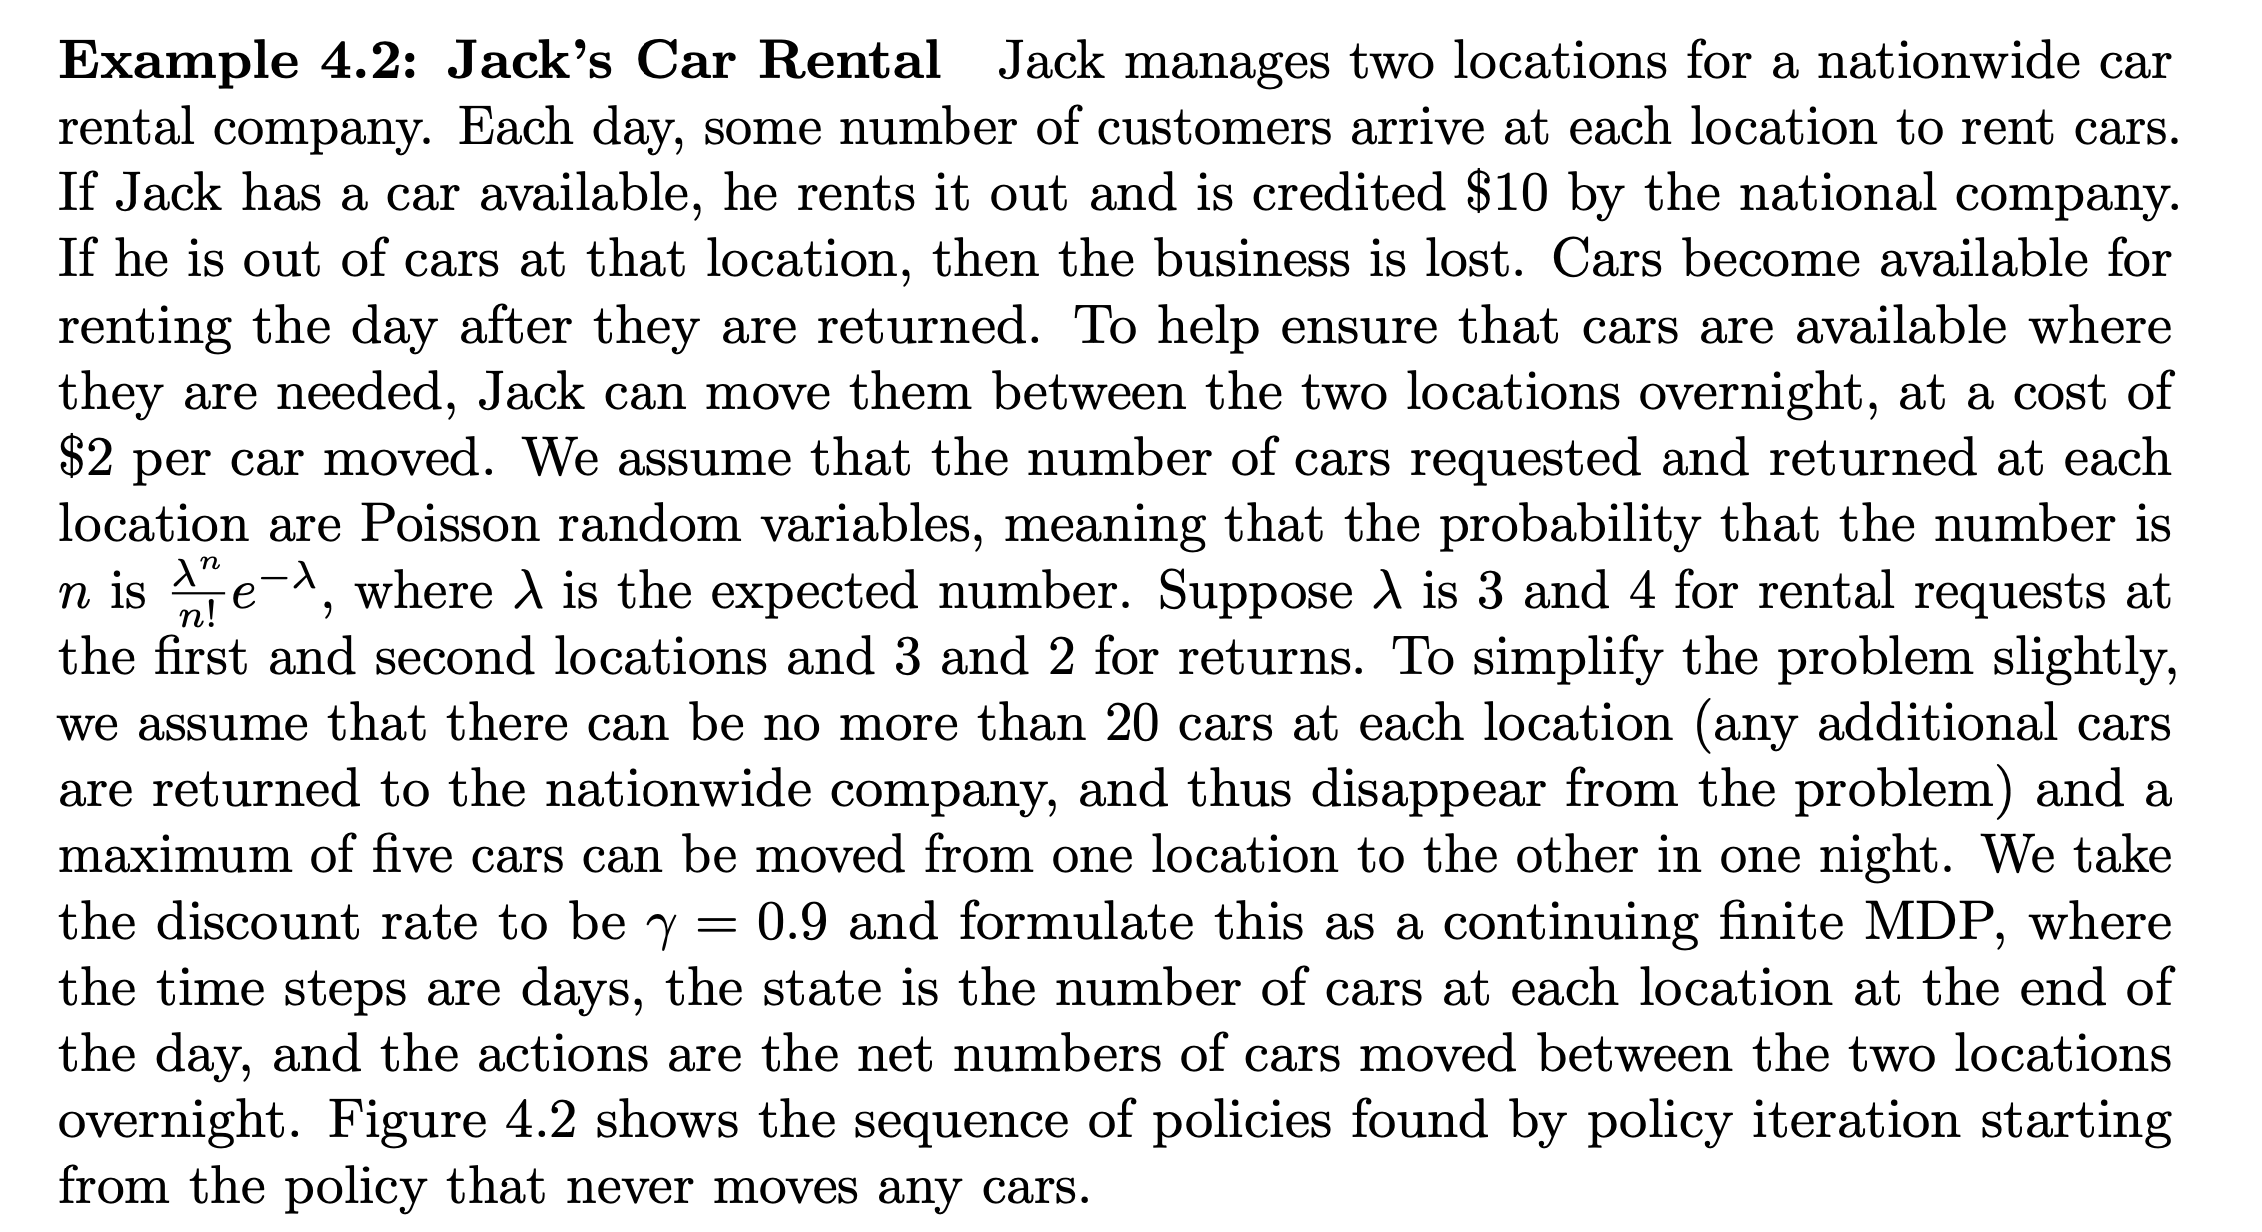
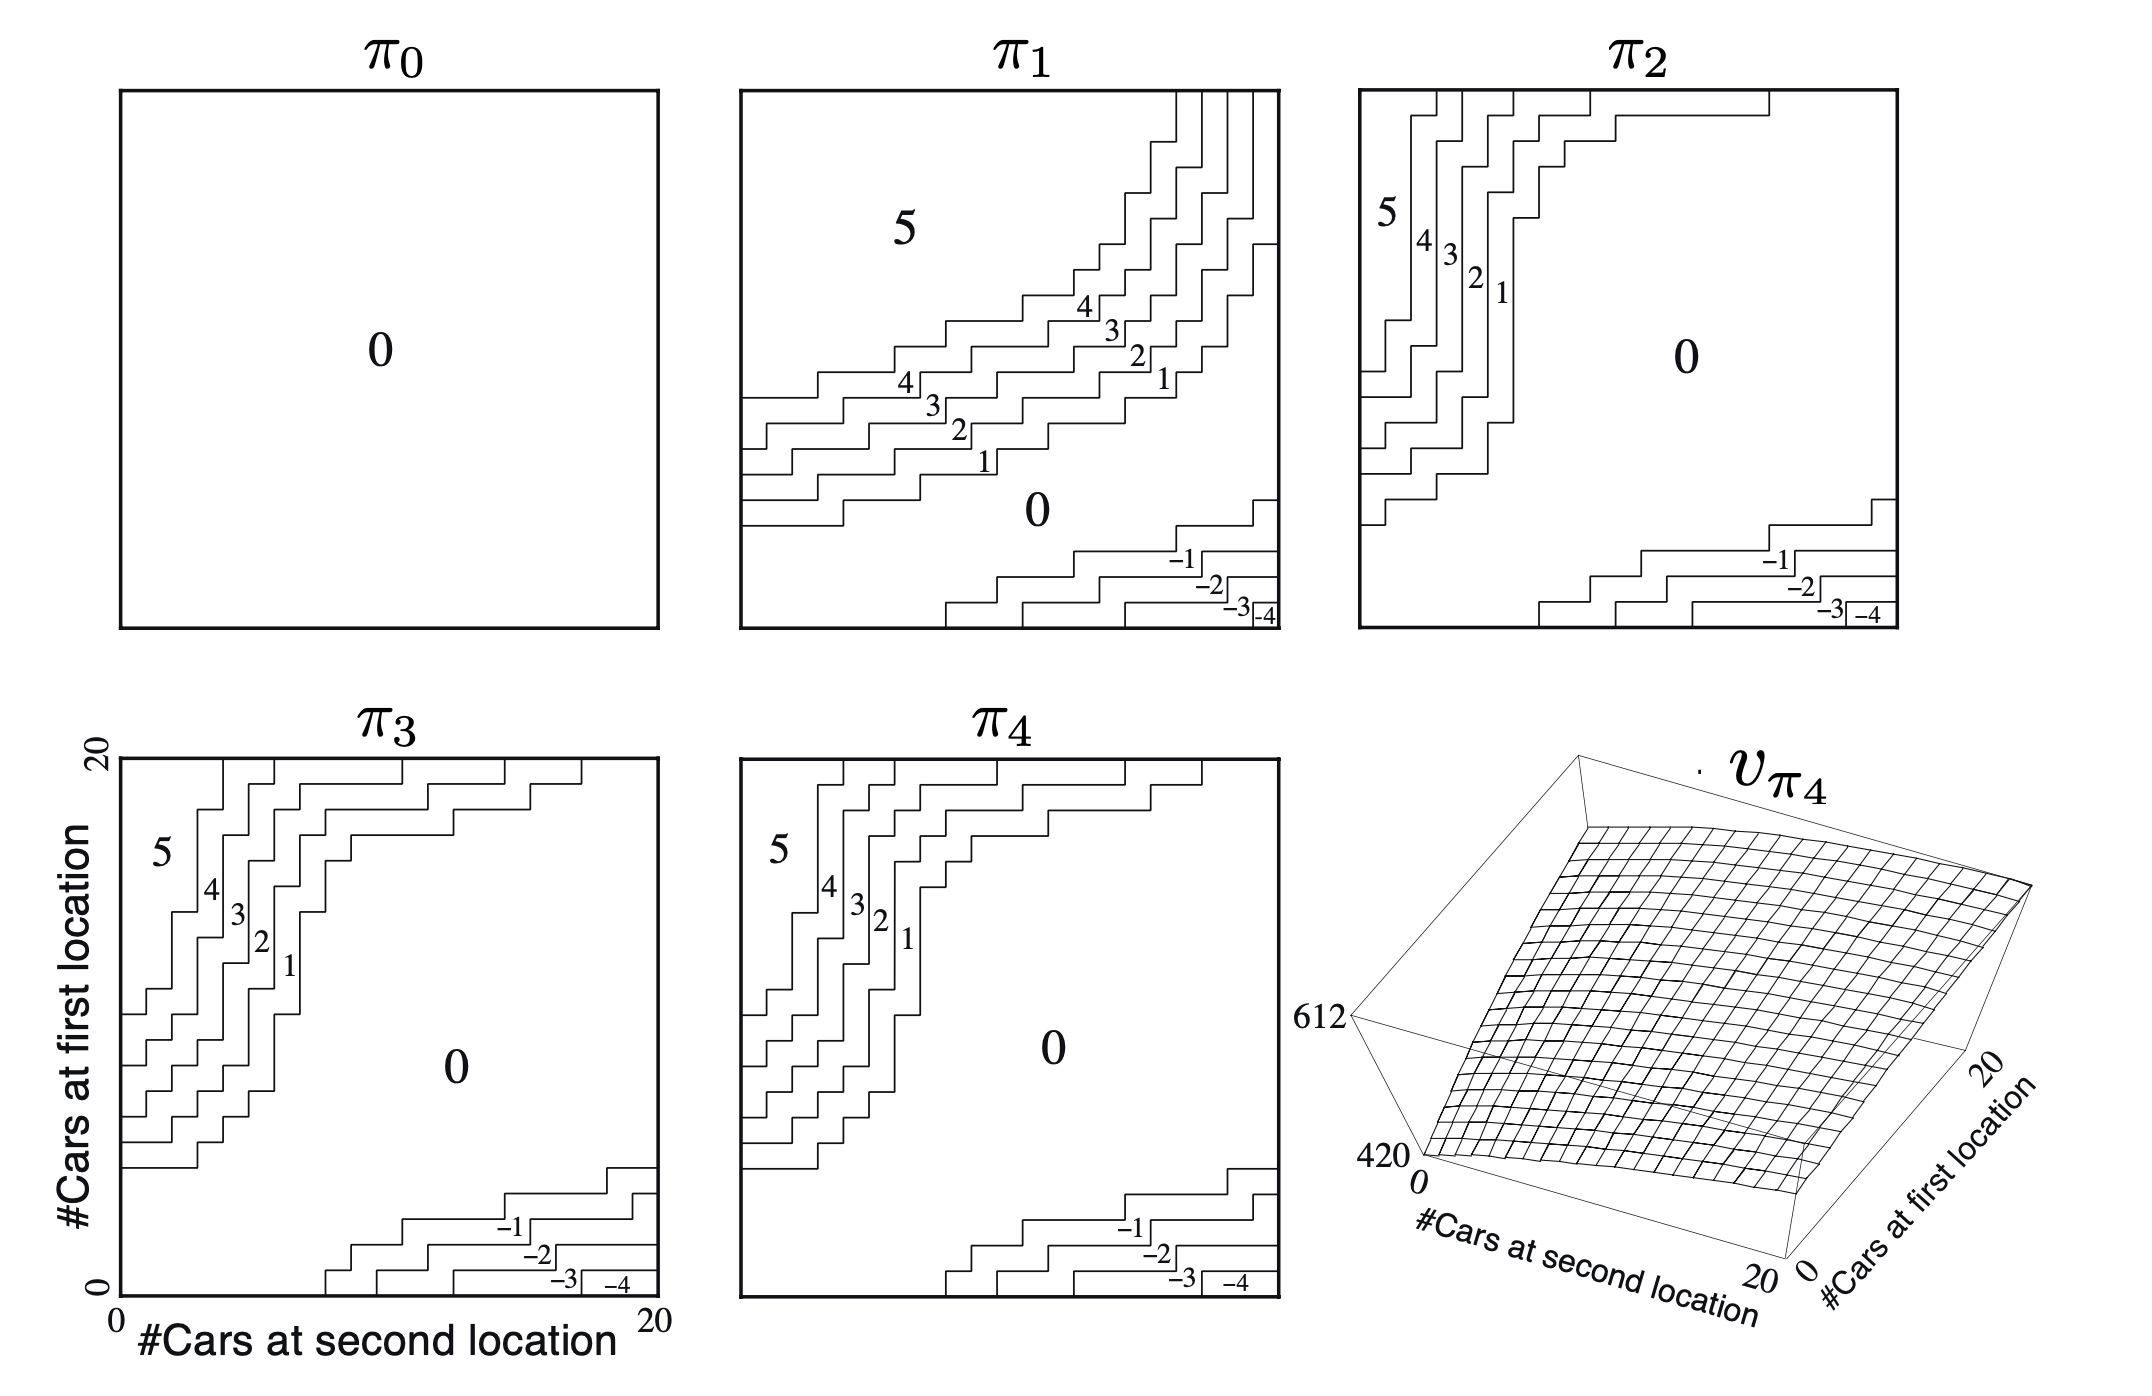

In [53]:
def calc_poisson(lam, max_cars=21):
    res = {}
    for i in range(max_cars):
        res[i] = max(np.finfo(float).eps, abs(np.power(lam, i) / (math.factorial(i)) * np.exp(-lam)))
    return res

In [54]:
# Constants
MAX_CARS = 20
DISCOUNT_RATE = 0.9

### Notes

State is how many cars at each place, and then action is somewhere on the range of (5, -4) moving cars between. Positive is moving to lot 2, and negative is moving to lot 1

In [55]:
"""
Creates the p(s', r | s, a) matrix, BUT since s' is always known, you can just do
p(r | s, a).
"""

# Number of cars left in lot 1 & lot 2
def calc_P(all_probs):
    p = {}
    for s_a, s_b in itertools.product(range(MAX_CARS + 1), range(MAX_CARS + 1)):
        # Positive action is moving from Lot A to B, and negative is from B to A
        for action in range(-5, 6):
            # Ensure you only do actions which are valid
            if (action > s_a or 
                -action > s_b or 
                action + s_b > 20 or 
                -action + s_a > 20):
                continue

            temp = defaultdict(float)

            # For customers & returns at each place
            # You can have any # of these happen from
            for c_a, c_b, r_a, r_b in product(range(MAX_CARS + 1), repeat=4):
                s_a_prime = min(MAX_CARS, s_a - min(s_a, c_a + action) + r_a)
                # s_a_prime = max(0, min(MAX_CARS, s_a + r_a - action - c_a))

                # If the stupid error was using a - instead of a +
                s_b_prime = min(MAX_CARS, s_b - min(s_b, c_b - action) + r_b)
                # s_b_prime = max(0, min(MAX_CARS, s_b + r_b + action - c_b))

                # Reward is # of customers you can satisfy tomorrow - cars you moved
                reward = 10 * min(c_a, s_a - action) \
                       + 10 * min(c_b, s_b + action) \
                       - abs(action) * 2
                temp[((s_a_prime, s_b_prime), reward)] += all_probs[(c_a, c_b, r_a, r_b)] 

                continue

            p[((s_a, s_b), action)] = temp
    return p
    # with open('P_transitions', 'wb') as f:
    #     pickle.dump(p, f)

In [56]:
def init():
    # Don't init if you've already computed transitions before
    if os.path.exists('P_transitions'):
        print('Not recalculating P_transitions')
        return
    a_rents = calc_poisson(3)
    b_rents = calc_poisson(4)
    a_returns = calc_poisson(3)
    b_returns = calc_poisson(2)

    all_poisson_poss = {}
    for c_a, c_b, r_a, r_b in product(range(MAX_CARS + 1), repeat=4):
        all_poisson_poss[(c_a, c_b, r_a, r_b)] = max(
            np.finfo(float).eps, 
            a_rents[c_a] * b_rents[c_b] * a_returns[r_a] * b_returns[r_b]
        ) 
    
    return calc_P(all_poisson_poss)


In [57]:
def policy_iteration(V, pi, gamma=0.9, theta=0.000_1):
    global p
    while True:
        delta = 0.0
        for s in V.keys():
            v = V[s]
            a = pi[s]

            V[s] = 0
            for (s_prime, r), prob in p[(s, a)].items():
                V[s] += prob * (r + gamma * V[s_prime])
            delta = max(delta, abs(V[s] - v))

        if delta < theta:
            return V

In [79]:
def policy_improvement(V, pi, gamma=0.9):
    global p
    while True:
        stable = True
        for s in V.keys():
            old_action = pi[s]
            (s_a, s_b) = s

            a_returns = np.zeros(11)
            for pos_action in range(-5, 6):
                action_idx = pos_action + 5

                if (pos_action > s_a or 
                    -pos_action > s_b or 
                    pos_action + s_b > 20 or 
                    -pos_action + s_a > 20):
                    a_returns[action_idx] = -1000
                    continue

                for (s_prime, r), prob in p[(s, pos_action)].items():
                    a_returns[action_idx] += prob * (r + gamma * V[s_prime])
            best_idxs = np.flatnonzero(a_returns == np.max(a_returns)).tolist()
            if (old_action + 5) not in best_idxs:
                pi[s] = best_idxs[0] - 5
                stable = False
            # if pi[s] != old_action:
            #     stable = False

        if stable:
            return pi

In [59]:
def show_policy_heatmap(pi):
    actions = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

    plt.figure(figsize=(8, 8))  # Adjusted figure size for clarity
    for a_c, b_c in product(range(MAX_CARS + 1), repeat=2):
        actions[a_c, b_c] = pi[(a_c, b_c)]

    plt.imshow(actions, origin='lower', cmap='viridis')
    # plt.colorbar(label='Action')
    for a_c, b_c in product(range(MAX_CARS + 1), repeat=2):
        plt.text(b_c, a_c, int(actions[(a_c, b_c)]) , ha='center', va='center', color='black')
    plt.axis('off')
    plt.show()


In [77]:
def train():
    V = {}
    pi = {}
    for i, j in product(range(MAX_CARS + 1), repeat=2):
        V[(i, j)] = 10 * np.random.uniform()
        pi[(i, j)] = 0
    
    # for i in tqdm(range(5)):
    for i in range(5):
        clear_output()
        print(f'> tr loop: iter {i:3d}')
        show_policy_heatmap(pi)
        V = policy_iteration(V, pi, theta=0.01)
        pi = policy_improvement(V, pi)

        with open('pi'+str(i), 'wb') as f:
            pickle.dump(pi, f)
        with open('V'+str(i), 'wb') as f:
            pickle.dump(V, f)

        # If you reach a stable policy, then you're done
        # Save & Print out heatmap of how it's doing?

In [61]:
# check if file exists and load, otherwise save it
global p
p = init()

100%|██████████| 441/441 [12:38<00:00,  1.72s/it]


In [62]:
# with open('P_transitions', 'rb') as f:
#     p = pickle.load(f)

> tr loop: iter   4


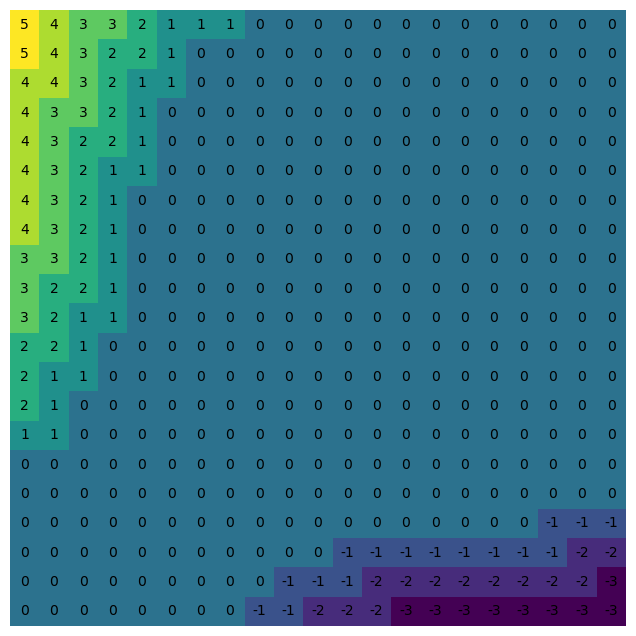

In [80]:
train()